In [1]:
import torch
from torch.distributions import StudentT,Normal,Laplace,Gamma, Bernoulli
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
from random import sample,seed
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from IPython.display import clear_output, display

In [2]:
from causal_cocycle.model import cocycle_model,flow_model
from causal_cocycle.optimise import *
from causal_cocycle.loss_functions import Loss
from causal_cocycle.conditioners import Constant_Conditioner, Lin_Conditioner,NN_RELU_Conditioner
from causal_cocycle.transformers import Transformer,Shift_layer,Scale_layer,RQS_layer
from causal_cocycle.helper_functions import likelihood_loss,mmd
from causal_cocycle.kernels import *
from causal_cocycle.regression_functionals import *
from causal_cocycle.distribution_estimation import *

In [3]:
# Helper functions
def feature_X(X):
    return torch.sigmoid((X-1))
    
def lr(X,Y):
    return torch.linalg.solve(X.T @ X, X.T @ Y)
    
def DGP(nu,sd,n,d=1):
    U = StudentT(nu,0,sd).sample((n,1))
    V = Normal(0,sd).sample((n,1))
    Z = Normal(0,1).sample((n,d))
    X = Z.mean(1)[:,None] + U
    Y = feature_X(X) + Z.mean(1)[:,None] + V
    
    return Z,X,Y,U,V

def DGP2(nu,sd,n,d=1):
    lmbda = StudentT(1,0,1).sample((n,1)).abs()
    U = sd*Normal(0,lmbda).sample()
    V = Normal(0,sd).sample((n,1))
    Z = Normal(0,1).sample((n,d))
    X = Z.mean(1)[:,None] + U
    Y = feature_X(X) + Z.mean(1)[:,None] + V
    
    return Z,X,Y,U,V

def DGP3(nu,sd,n,d=1):
    Bu = Bernoulli(0.5).sample((n,1))
    Bv = Bernoulli(0.5).sample((n,1))
    U = sd*(+Bu*Normal(0,1).sample((n,1)).abs() - (1-Bu)*StudentT(nu,0,1).sample((n,1)).abs())
    V = (+Bv*Normal(0,1).sample((n,1)).abs() - (1-Bv)*StudentT(nu,0,1).sample((n,1)).abs())
    Z = Normal(0,1).sample((n,d))
    X = Z.mean(1)[:,None] + U
    Y = feature_X(X) + Z.mean(1)[:,None] + V
    
    return Z,X,Y,U,V
    
def kernel(X,Z,l):
    return torch.exp(-l*torch.cdist(X,Z)**2)

def Dist_est(f,intervention,int_level,cate_grid,U):
    return (f(intervention(int_level,cate_grid + U.T)) 
            - f(cate_grid + U.T))

def CATE_est(f,intervention,int_level,cate_grid,U):
    return Dist_est(f,intervention,int_level,cate_grid,U).mean(1)

def Prob_est(f,intervention,int_level,cate_grid,U, thresh):
    return (Dist_est(f,intervention,int_level,cate_grid,U)<=thresh).float().mean()

def studentT_likelihood_opt(X,niter,nu=1.0, learn_tails = False):
    sigma = torch.ones(1,requires_grad = True)
    params = [sigma]
    if learn_tails:
        nu = torch.tensor(nu,requires_grad = True)
        params.append(nu)
    optimizer = torch.optim.Adam(params, lr = 0.01)
    for i in range(niter):
        optimizer.zero_grad()
        loss = -StudentT(nu.abs()+1,0,sigma.abs()).log_prob(X).mean()
        loss.backward()
        optimizer.step()
    return sigma,nu.abs()+1

def mixed_likelihood_opt(X,niter):
    sigma = torch.ones(1,requires_grad = True)
    params = [sigma]
    optimizer = torch.optim.Adam(params, lr = 0.01)
    for i in range(niter):
        optimizer.zero_grad()
        loss = (-StudentT(1,0,1).log_prob(X[X>0]/sigma.abs()).sum()
                -Normal(0,1).log_prob(X[X<=0]/sigma.abs()).sum() 
                - torch.log(sigma.abs())
               )
        loss.backward()
        optimizer.step()
    return sigma.abs()

class MixtureDist:

    def __init__(self,sd):
        self.sd = torch.tensor(sd,requires_grad = True)

    def sample(self, shape):
        B = Bernoulli(0.5).sample(shape)
        N = self.sd*Normal(0,1).sample(shape).abs()
        C = self.sd*StudentT(1,0,1).sample(shape).abs()
        return +B*N - (1-B)*C

    def log_prob(self, X):
        return (
            -StudentT(1,0,1).log_prob(X[X[:,0]<0]/self.sd.abs()).sum()
            -Normal(0,1).log_prob(X[X[:,0]>=0]/self.sd.abs()).sum() 
            - torch.log(self.sd.abs())
               )
            
    
class likelihood_loss:
    
    def __init__(self,dist):
        self.dist = dist
        if hasattr(dist,'df'):
            self.parameters = self.dist.df.requires_grad_(True)
        else:
            self.parameters = torch.tensor(1.0)
        self.loss_fn = "MLE"
    
    def __call__(self,model,inputs,outputs):
        U,logdet = model.inverse_transformation(inputs,outputs)
        
        return torch.mean(-self.dist.log_prob(U) - logdet) 

In [4]:
# Experimental settings
n = 500 # training samples
d = 1 # input dims
trials = 5 # experiment replications
ngrid = 100 # grid points for CATE
zlist = torch.linspace(-2,2,ngrid)[:,None]/d**0.5 # grid generation for CATE
nu = 1 # DoF
sd = 1.0 # \sigma^2 on Y|X,Z
mc_samples = 10**5 # MC samples to approx expectations
hyper_ls = 2**torch.linspace(-2,2,5)

# Interventions
intervention_hard = lambda a,x : a + x*0
intervention_shift = lambda a,x : a + x
intervention_scale = lambda a,x : a*x
interventions = [intervention_shift]

In [5]:
# Training set up
train_val_split = 1
ntrain = int(n)
learn_rate = [1e-2]
scheduler = False
val_tol = 1e-3
batch_size = 64
val_loss = False
maxiter = 3000
miniter = 3000
RQS_bins = 8
df_init = 10.0

# Model names
Models = ["Empirical", "RQS SCM","L-RQS SCM", "TA-RQS SCM"]


# Models
SCM_models = [[] for i in range(len(Models))]
Cocycle_models = []

tail_adapt = [False,False,False, True]

# Intervention_level
a = torch.tensor([1.0])

grad = True

In [6]:
# Estimated CATEs
CATEs_param_est = torch.zeros(len(Models),len(interventions),trials,ngrid)
for t in range(trials):
    
    # Seed set
    seed(t)
    torch.manual_seed(t)
    
    # Getting sample data
    (Z,X,Y,U,V) = DGP3(nu,sd,n)
    data_pairs = [torch.column_stack((Z,X)),
                  torch.column_stack((Z,feature_X(X),Y))]

    # base distributions
    SCM_base_distributions = [[MixtureDist(1.0),MixtureDist(1.0)],
                          [Normal(0,1),Normal(0,1)],
                          [Laplace(0,1),Laplace(0,1)],
                          [StudentT(df_init, 0,1),StudentT(df_init, 0,1)],
                         ]
    
    # Transformers and conditioners
    SCM_conditioners = [
        [[Lin_Conditioner(1,1, bias = False, grad = grad, init = 1.0),
          Constant_Conditioner(init = torch.log(torch.exp(torch.ones(1))-1), grad = grad, full = False)],
         [Lin_Conditioner(2,1, bias = False, grad = False, init = 1.0),
          Constant_Conditioner(init = torch.log(torch.exp(torch.ones(1))-1), grad = grad, full = False)]],
        [[Lin_Conditioner(1,1, bias = False, grad = grad, init = 1.0),
          Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
         [Lin_Conditioner(2,1, bias = False, grad = grad, init = 1.0),
          Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)]],
        [[Lin_Conditioner(1,1, bias = False, grad = grad, init = 1.0),
          Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
        [Lin_Conditioner(2,1, bias = False, grad = grad, init = 1.0),
          Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)]],
         [[Lin_Conditioner(1,1, bias = False, grad = grad, init = 1.0),
          Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
        [Lin_Conditioner(2,1, bias = False, grad = grad, init = 1.0),
          Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)]],
    ]
    SCM_transformers = [
        [Transformer([Shift_layer(),Scale_layer()],logdet = True)]*2,
        [Transformer([Shift_layer(),RQS_layer(),Shift_layer(),Scale_layer()],logdet = True)]*2,
        [Transformer([Shift_layer(),RQS_layer(),Shift_layer(),Scale_layer()],logdet = True)]*2,
        [Transformer([Shift_layer(),RQS_layer(),Shift_layer(),Scale_layer()],logdet = True)]*2,
    ]
    
    # Model estimation
    for i in range(len(data_pairs)):
        
        # Getting input-output pairs
        inputs_train,outputs_train = data_pairs[i][:,:-1],data_pairs[i][:,-1:]
        inputs_val,outputs_val = [],[]
    
        # SCM training
        for m in range(len(SCM_models)):
            loss_fn = likelihood_loss(dist = SCM_base_distributions[m][i])
            model = flow_model(SCM_conditioners[m][i],SCM_transformers[m][i])
            if m > 0:
                model.transformer.logdet = True
                optimise(model,
                              loss_fn,
                              inputs_train,
                              outputs_train,
                              inputs_val,
                              outputs_val, 
                              batch_size = batch_size,
                              learn_rate = learn_rate,
                              print_ = True,
                              plot = False, 
                              miniter = miniter,
                              maxiter = maxiter, 
                              val_tol = val_tol,
                              val_loss = val_loss,
                              scheduler = scheduler,
                              likelihood_param_opt = True)
            model.transformer.logdet = False
            SCM_models[m].append(model)

            if tail_adapt[m]:
                SCM_base_distributions[m][i] = StudentT(SCM_base_distributions[m][i].df.detach(),0,1)
    
    print(t)

    # Estimated CATEs
    Yints, Ys = [],[]
    for i in range(len(interventions)):
        for m in range(len(SCM_models)):
            if m == 0:
                samples = n
            else:
                samples = mc_samples
            Yintz_sample,Yz_sample = torch.zeros((ngrid,samples)),torch.zeros((ngrid,samples))
            Usample = SCM_base_distributions[m][0].sample((samples,1))
            for z in range(len(zlist)):
                if m == 0:
                    Xz_sample = Usample+zlist[z]
                    Yz_sample[z] = (feature_X(Xz_sample) + zlist[z]).T
                    Yintz_sample[z] = (feature_X(interventions[i](a,Xz_sample)) + zlist[z]).T
                else:
                    Xz_sample = SCM_models[m][0].transformation(zlist[z]* torch.ones((len(Usample),1)),Usample).detach()
                    Yz_sample[z] = SCM_models[m][1].conditioner[0].forward(torch.column_stack((Xz_sample,feature_X(Xz_sample)))).detach().T
                    Yintz_sample[z] = SCM_models[m][1].conditioner[0].forward(torch.column_stack((Xz_sample,feature_X(interventions[i](a,Xz_sample))))).detach().T                    
    
            #Yints.append(Yintz_sample)
            #Ys.append(Yz_sample)
            CATEs_param_est[m,i,t] = (Yintz_sample-Yz_sample).float().mean(1).detach()

Training loss last 10 avg is : tensor(1.9302)
99.66666666666667  % completion
4


In [7]:
    # Estimated CATEs
    Yints, Ys = [],[]
    for i in range(len(interventions)):
        for m in range(len(SCM_models)):
            if m == 0:
                samples = n
            else:
                samples = mc_samples
            Yintz_sample,Yz_sample = torch.zeros((ngrid,samples)),torch.zeros((ngrid,samples))
            Usample = SCM_base_distributions[m][0].sample((samples,1))
            for z in range(len(zlist)):
                if m == 0:
                    Xz_sample = Usample+zlist[z]
                    Yz_sample[z] = (feature_X(Xz_sample) + zlist[z]).T
                    Yintz_sample[z] = (feature_X(interventions[i](a,Xz_sample)) + zlist[z]).T
                else:
                    Xz_sample = SCM_models[m][0].transformation(zlist[z]* torch.ones((len(Usample),1)),Usample).detach()
                    Yz_sample[z] = SCM_models[m][1].conditioner[0].forward(torch.column_stack((Xz_sample,feature_X(Xz_sample)))).detach().T
                    Yintz_sample[z] = SCM_models[m][1].conditioner[0].forward(torch.column_stack((Xz_sample,feature_X(interventions[i](a,Xz_sample))))).detach().T                    
    
            #Yints.append(Yintz_sample)
            #Ys.append(Yz_sample)
            CATEs_param_est[m,i,t] = (Yintz_sample-Yz_sample).float().mean(1).detach()

In [8]:
# True CATEs
U = MixtureDist(1.0).sample((10**5,1))
CATEs_true = []
CATEs_est = []
for i in range(len(interventions)):
    CATEs_true.append((Dist_est(feature_X,interventions[i],a,zlist,U)).float().mean(1).detach())
    CATEs_est.append((Dist_est(feature_X,interventions[i],a,zlist,U[:n])).float().mean(1).detach())

CATEs_true, CATEs_est

([tensor([0.0817, 0.0838, 0.0859, 0.0881, 0.0902, 0.0924, 0.0946, 0.0969, 0.0991,
          0.1014, 0.1037, 0.1059, 0.1082, 0.1105, 0.1128, 0.1151, 0.1174, 0.1198,
          0.1220, 0.1243, 0.1266, 0.1289, 0.1311, 0.1334, 0.1356, 0.1378, 0.1399,
          0.1421, 0.1442, 0.1462, 0.1483, 0.1503, 0.1522, 0.1541, 0.1560, 0.1578,
          0.1595, 0.1612, 0.1629, 0.1645, 0.1660, 0.1674, 0.1688, 0.1701, 0.1714,
          0.1726, 0.1737, 0.1747, 0.1756, 0.1765, 0.1773, 0.1780, 0.1786, 0.1792,
          0.1796, 0.1800, 0.1803, 0.1805, 0.1806, 0.1807, 0.1806, 0.1805, 0.1803,
          0.1800, 0.1797, 0.1792, 0.1787, 0.1781, 0.1774, 0.1766, 0.1758, 0.1749,
          0.1740, 0.1729, 0.1718, 0.1707, 0.1694, 0.1681, 0.1668, 0.1654, 0.1639,
          0.1624, 0.1609, 0.1593, 0.1577, 0.1560, 0.1543, 0.1525, 0.1507, 0.1489,
          0.1471, 0.1452, 0.1433, 0.1414, 0.1395, 0.1376, 0.1356, 0.1336, 0.1316,
          0.1297])],
 [tensor([0.0803, 0.0824, 0.0845, 0.0866, 0.0888, 0.0910, 0.0932, 0.0954, 0.0

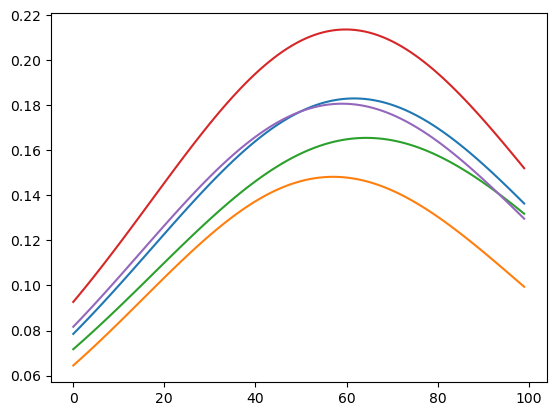

In [9]:
plt.plot(CATEs_param_est[:,0,1,:].detach().T)
plt.plot(CATEs_true[0].detach())
CATEs_param_est = CATEs_param_est.detach()

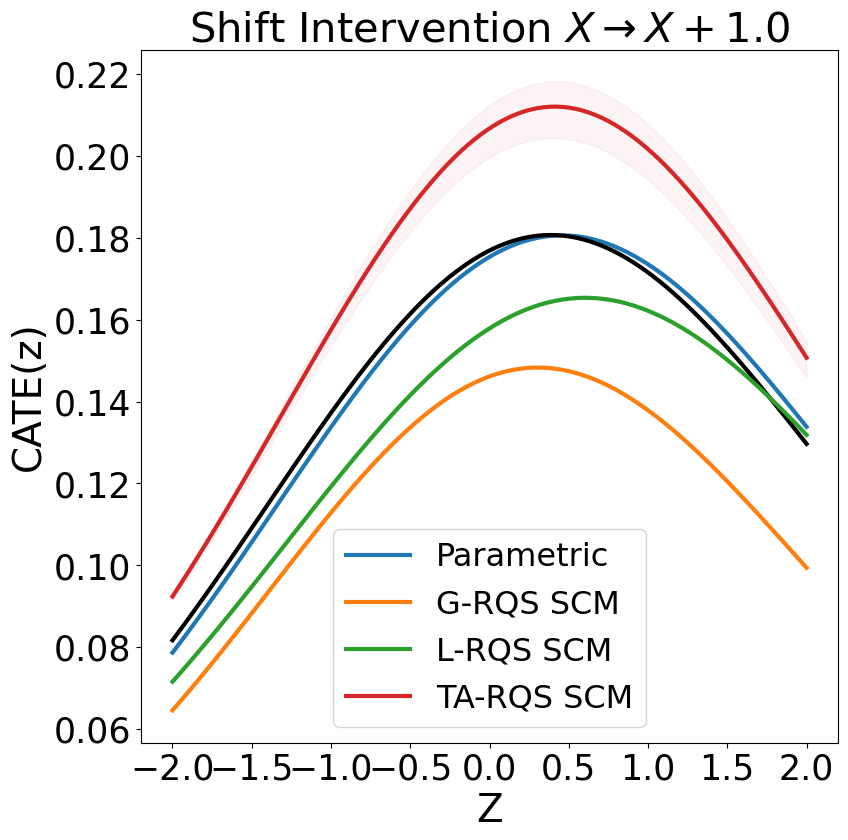

In [10]:
"""
Plotting results
"""
Models = ["Parametric", "G-RQS SCM","L-RQS SCM","TA-RQS SCM"]

# Plot settings
figsize = (9,9)
quantile = 0.95
fontsize = 30
alpha = 0.05
model_select = [0,1,2,3]
plot_trials = 5


# Plot labels
plot_labels = Models
plot_titles = [r"Shift Intervention $X \to X+{0}$".format(a[0]),
               r"Scale Intervention $X \to {0}X$".format(a[0]),
               r"Hard Intervention $X \to {0}$".format(a[0])]

#plt.rcParams["image.cmap"] = "plasma"
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
#colours[len(Models)-1] = '#2ca02c'
#colours = ["black",'#1f77b4','#d62728','#ff7f0e','#1f77b4','#2ca02c']
linestyles = ["solid","solid","solid","solid","solid","solid","dashed"]
#linestyles = ["solid","dashed","dashed","solid","dashed","solid"]
linewidths = [3,3,3,3,3,3,5]
alphas = [0,alpha,alpha,alpha,alpha,alpha,alpha]
    
plot_filenames = ["CATE_example_shift_SCM_fixed_features_N={0}_trials={1}_nu={2}_int={3}_all".format(n,trials,nu,int(a)),
                 "CATE_example_scale_SCM_fixed_features_N={0}_trials={1}_nu={2}_int={3}_all".format(n,trials,nu,int(a)),
                 "CATE_example_hard_SCM_fixed_features_N={0}_trials={1}_nu={2}_int={3}_all".format(n,trials,nu,int(a))]
    
# Plotting
for i in range(len(interventions)):
    fig,axs = plt.subplots(figsize = figsize)
    plt.title(plot_titles[i],fontsize = fontsize)
    plt.xlabel(r"Z",fontsize = fontsize-2)
    plt.ylabel(r"CATE(z)",fontsize = fontsize-2)
    plt.xticks(fontsize = fontsize-5)
    plt.yticks(fontsize = fontsize-5)
    plt.plot(zlist,CATEs_true[i], color = "black", lw = 3)
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    for j in model_select:
        mean = torch.mean(CATEs_param_est[j][i][:plot_trials],0).detach()
        if j == 0:
            upper,lower = mean,mean
        else:
            upper = CATEs_param_est[j][i][:plot_trials].quantile(quantile,0)
            lower = CATEs_param_est[j][i][:plot_trials].quantile(1-quantile,0)
        plt.plot(zlist,mean,label = plot_labels[j],lw =linewidths[j],color = colours[j], linestyle = linestyles[j],zorder = j)
        plt.fill_between(zlist[:,0],lower,upper, alpha = alphas[j],color = colours[j])
    if i ==len(interventions)-1:
        plt.legend(fontsize = fontsize-7)
    plt.show()
    #fig.savefig(plot_filenames[i].format(n,trials,nu,int(a)),bbox_inches = "tight")

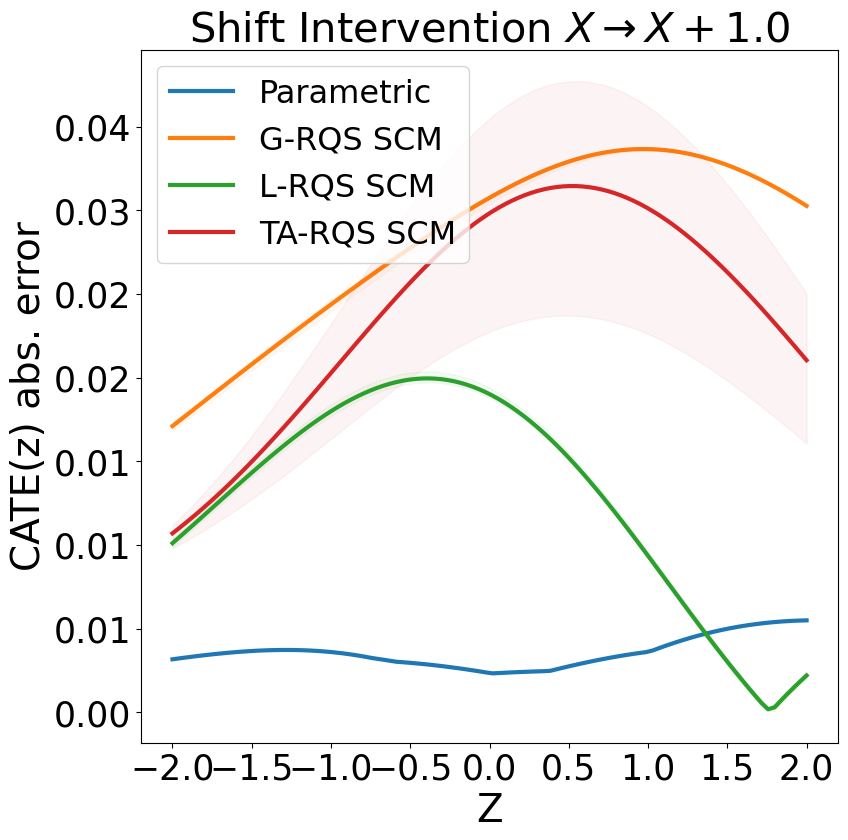

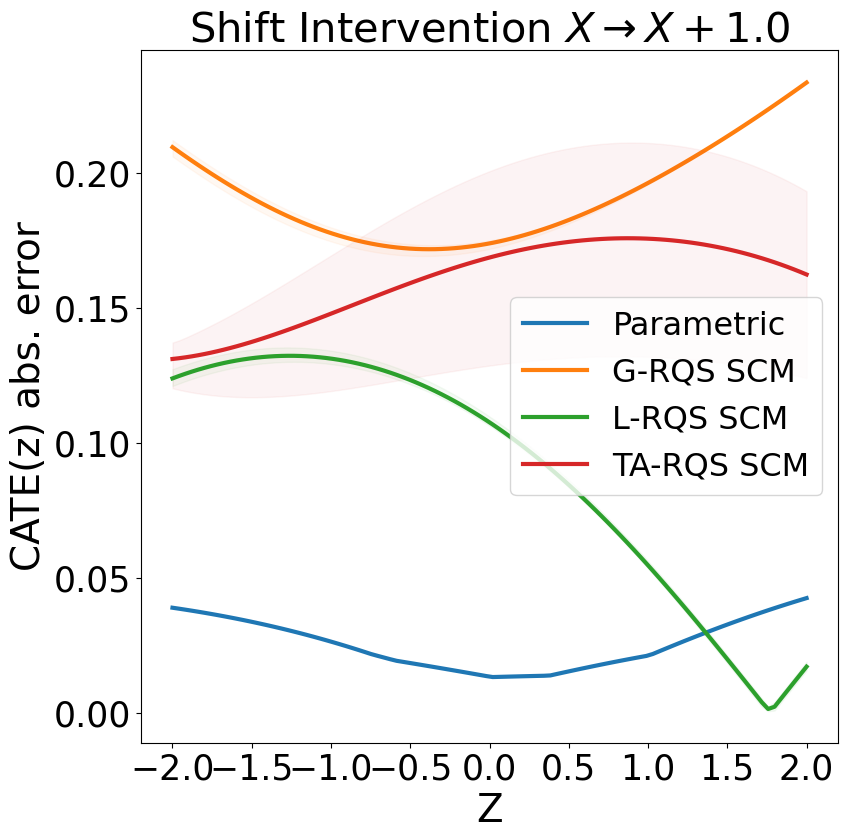

In [11]:
"""
Plotting results
"""
Models = ["Parametric", "G-RQS SCM","L-RQS SCM","TA-RQS SCM"]

# Plot settings
figsize = (9,9)
quantile = 0.95
fontsize = 30
alpha = 0.05
model_select = [0,1,2,3]
plot_trials = 5


# Plot labels
plot_labels = Models
plot_titles = [r"Shift Intervention $X \to X+{0}$".format(a[0]),
               r"Scale Intervention $X \to {0}X$".format(a[0]),
               r"Hard Intervention $X \to {0}$".format(a[0])]

#plt.rcParams["image.cmap"] = "plasma"
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
#colours[len(Models)-1] = '#2ca02c'
#colours = ["black",'#1f77b4','#d62728','#ff7f0e','#1f77b4','#2ca02c']
linestyles = ["solid","solid","solid","solid","solid","solid","dashed"]
#linestyles = ["solid","dashed","dashed","solid","dashed","solid"]
linewidths = [3,3,3,3,3,3,5]
alphas = [0,alpha,alpha,alpha,alpha,alpha,alpha]
    
plot_filenames = ["CATE_example_shift_SCM_fixed_features_N={0}_trials={1}_nu={2}_int={3}_all_error".format(n,trials,nu,int(a)),
                 "CATE_example_scale_SCM_fixed_features_N={0}_trials={1}_nu={2}_int={3}_all_error".format(n,trials,nu,int(a)),
                 "CATE_example_hard_SCM_fixed_features_N={0}_trials={1}_nu={2}_int={3}_all_error".format(n,trials,nu,int(a))]
    
# Plotting
for i in range(len(interventions)):
    fig,axs = plt.subplots(figsize = figsize)
    plt.title(plot_titles[i],fontsize = fontsize)
    plt.xlabel(r"Z",fontsize = fontsize-2)
    plt.ylabel(r"CATE(z) abs. error",fontsize = fontsize-2)
    plt.xticks(fontsize = fontsize-5)
    plt.yticks(fontsize = fontsize-5)
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    for j in model_select:
        mean = torch.mean((CATEs_param_est[j][i]-CATEs_true[i])[:plot_trials].abs(),0).detach()
        if j == 0:
            upper,lower = mean,mean
        else:
            upper = (CATEs_param_est[j][i]-CATEs_true[i].detach())[:plot_trials].abs().quantile(quantile,0)
            lower = (CATEs_param_est[j][i]-CATEs_true[i].detach())[:plot_trials].abs().quantile(1-quantile,0)
        plt.plot(zlist,mean,label = plot_labels[j],lw =linewidths[j],color = colours[j], linestyle = linestyles[j],zorder = j)
        plt.fill_between(zlist[:,0],lower,upper, alpha = alphas[j],color = colours[j])
    if i ==len(interventions)-1:
        plt.legend(fontsize = fontsize-7)
    plt.show()
    #fig.savefig(plot_filenames[i].format(n,trials,nu,int(a)),bbox_inches = "tight")

# Plotting
for i in range(len(interventions)):
    fig,axs = plt.subplots(figsize = figsize)
    plt.title(plot_titles[i],fontsize = fontsize)
    plt.xlabel(r"Z",fontsize = fontsize-2)
    plt.ylabel(r"CATE(z) abs. error",fontsize = fontsize-2)
    plt.xticks(fontsize = fontsize-5)
    plt.yticks(fontsize = fontsize-5)
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    for j in model_select:
        mean = (CATEs_param_est[j][i]-CATEs_true[i])[:plot_trials].abs().mean(0).detach()/CATEs_true[i]
        if j == 0:
            upper,lower = mean,mean
        else:
            upper = (CATEs_param_est[j][i]-CATEs_true[i].detach())[:plot_trials].abs().quantile(quantile,0)/CATEs_true[i]
            lower = (CATEs_param_est[j][i]-CATEs_true[i].detach())[:plot_trials].abs().quantile(1-quantile,0)/CATEs_true[i]
        plt.plot(zlist,mean,label = plot_labels[j],lw =linewidths[j],color = colours[j], linestyle = linestyles[j],zorder = j)
        plt.fill_between(zlist[:,0],lower,upper, alpha = alphas[j],color = colours[j])
    if i ==len(interventions)-1:
        plt.legend(fontsize = fontsize-7)
    plt.show()
    #fig.savefig(plot_filenames[i].format(n,trials,nu,int(a)),bbox_inches = "tight")

# Testing different distributional effects on cate

tensor(0.1411) tensor(0.1480) tensor(0.1776)


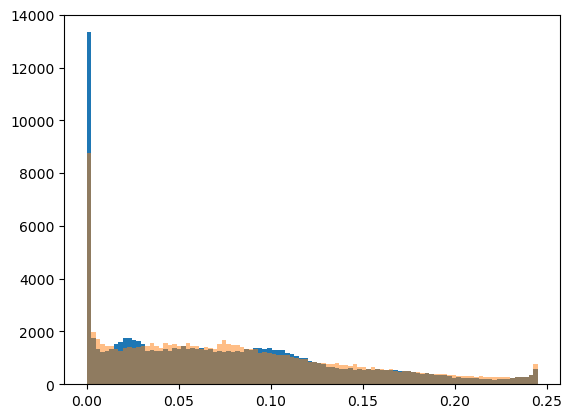

In [13]:
a = torch.tensor([1.0])
z = -2
sc = 1.0
mod = 1
B = Bernoulli(0.5).sample((10**5,1))
U = (+B*Normal(0,1).sample((10**5,1)).abs() - (1-B)*StudentT(1,0,1).sample((10**5,1)).abs())*sd
#U = StudentT(1,0,1).sample((10**5,1))*sd
Usample = SCM_base_distributions[mod][0].sample((mc_samples,1))
Xz_sample = SCM_models[mod][0].transformation(z * torch.ones((len(Usample),1)),Usample).detach()
effect_est = torch.sigmoid((Xz_sample[:,0]+a-1)/sc)-torch.sigmoid((Xz_sample[:,0]-1)/sc)
effect = torch.sigmoid((U[:,0]+z+a-1)/sc)-torch.sigmoid((U[:,0]+z-1)/sc)
effect_emp = torch.sigmoid((U[:500,0]+z+a-1)/sc)-torch.sigmoid((U[:500,0]+z-1)/sc)
plt.hist(effect_est, bins = 100);
plt.hist(effect, bins = 100, alpha = 0.5);

q = 0.01
print((effect<=q).float().mean(),(effect_emp<=q).float().mean(),(effect_est<=q).float().mean())